## Order data and last purchase made by pharmacy.

In [4]:
import csv
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
localtz = timezone('Asia/Dhaka')
date_format = '%Y-%m-%d %H:%M:%S'
from common.enums import Status
from pharmacy.enums import DistributorOrderType, PurchaseType
days_to_calculate = 30
end_date = datetime.now(timezone('Asia/Dhaka'))
start_date = end_date - timedelta(days=days_to_calculate)
io_logs = StockIOLog.objects.filter(
    purchase__id__in=Purchase.objects.select_related(
        'distributor',
        'organization',
        'distributor_order_group',
        'purchase'
    ).filter(
        created_at__gte=start_date,
        created_at__lte=end_date,
        status=13,
        distributor_order_type=2,
        purchase_type=4,
    ).exclude(current_order_status__in=[7, 8]).values_list('id',flat=True),
    # stock__id=7773163
).select_related(
    'stock',
).extra(
    select={'day': 'date(date)'}
).values(
    'stock__id', 
    'stock__product_full_name', 
    'day' ,
    'quantity'
).annotate(
    sold=Sum('quantity')
).values(
    'stock__id', 
    'stock__product_full_name', 
    'day' ,
    'sold'
).order_by(
    'stock__id', 
    'stock__product_full_name', 
    'day' ,
)
sales_data = { 
    'id' : [] ,
    'day' : [] ,
    'name' : [] , 
    'sold' : [],
}
for data in io_logs:
    sales_data['day'].append(data['day'])
    sales_data['id'].append(data['stock__id'])
    sales_data['name'].append(data['stock__product_full_name'])
    sales_data['sold'].append(data['sold'])
data_frame = pd.DataFrame.from_dict(sales_data)
total_order = data_frame.pivot_table(
    index = ["id","name"], 
    columns = "day" , 
    values = "sold", 
    aggfunc = "sum",
    margins=True
).fillna('-')
pending_order_io_logs = StockIOLog.objects.filter(
    purchase__id__in=Purchase.objects.select_related(
        'distributor',
        'organization',
        'distributor_order_group',
        'purchase'
    ).filter(
        created_at__gte=start_date,
        created_at__lte=end_date,
        status=13,
        distributor_order_type=2,
        purchase_type=4,
        current_order_status=2
    ).values_list('id',flat=True),
    # stock__id=7773163
).select_related(
    'stock',
).values(
    'stock__id', 
    'stock__product_full_name', 
    'quantity'
).annotate(
    sell_pending=Sum('quantity')
).values(
    'stock__id', 
    'stock__product_full_name', 
    'sell_pending'
).order_by(
    'stock__id', 
    'stock__product_full_name', 
)
new_order_data = { 
    'id' : [] ,
    'name' : [],
    'sell_pending' : []    
}
for data in pending_order_io_logs:
    new_order_data['id'].append(data['stock__id'])
    new_order_data['name'].append(data['stock__product_full_name'])
    new_order_data['sell_pending'].append(data['sell_pending'])
pending_order = pd.DataFrame.from_dict(new_order_data)
total_data_frame = total_order.merge(pending_order, on=['id', 'name'], how='left')
total_data_frame['avg'] = total_data_frame['All']/days_to_calculate
total_data_frame["sell_pending"] = total_data_frame["sell_pending"].fillna(0)
total_data_frame["demand"] = total_data_frame["sell_pending"] + total_data_frame["avg"]
total_data_frame.drop(['All' , 'id'], axis=1, inplace=True)
total_data_frame.to_csv('purchase_prediction_and_trend.csv')
print('exporting done!')

exporting done!


In [1]:
import csv
from datetime import date, datetime, timedelta

import pandas as pd
from core.enums import OrganizationType

orgs = Organization.objects.filter(type=OrganizationType.DISTRIBUTOR_BUYER)

def get_tz_date(d):
    from pytz import timezone
    localtz = timezone('Asia/Dhaka')
    date_format = '%Y-%m-%d %H:%M:%S'
    date_ = localtz.localize(datetime.strptime(f"{d} 00:00:00", date_format))
    return date_


with open("order-data-and-last-purchase-date-per-pharmacy.csv", mode='w') as file_:
    writer = csv.writer(file_, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    writer.writerow(['ID', 'Name', 'Address', 'Purchase Count', 'Total Sum', 'Avg Amount', 'Created At', '7 Days Amount', 'Min Date', 'Max Date', 'Diff Min/Max Date', 'Diff Last Purchase'])
    for org in orgs:
        created_at = org.created_at.date()
        seven_days = get_tz_date(created_at + timedelta(days=7))
        purchases = org.purchase_set.filter(
            status=13,distributor_order_type=2,purchase_type=4).exclude(current_order_status__in=[7, 8])
        aggr = purchases.aggregate(Sum('grand_total'), Avg('grand_total'), Min('created_at'), Max('created_at'))
        count = purchases.count()
        if count:
            min_date = aggr['created_at__min'].date()
            max_date = aggr['created_at__max'].date()
            seven_days_amount = purchases.filter(created_at__gte=seven_days).aggregate(Sum('grand_total')).get('grand_total__sum', 0)
            writer.writerow([org.id, org.name.title(), org.address.replace(',', ';'), count, aggr['grand_total__sum'], aggr['grand_total__avg'], created_at, seven_days_amount, min_date, max_date, (max_date - min_date).days, (date.today() - max_date).days])
        else:
            writer.writerow([org.id, org.name.title(), org.address.replace(',', ';'), count, 0, 0, created_at, 0])
    
df = pd.read_csv("order-data-and-last-purchase-date-per-pharmacy.csv")
# Preview the first 5 lines of the loaded data 
df.tail(10)


,ID,Name,Address,Purchase Count,Total Sum,Avg Amount,Created At,7 Days Amount,Min Date,Max Date,Diff Min/Max Date,Diff Last Purchase
913,791,Z Pharma,Alatunnasa school road ; dokhin badda;,0,0.0,0.000000,2020-07-22,0.0,NaN,NaN,NaN,NaN
914,1042,Zaman Drug House,766/1; Begum Rokeya Soroni; Seorapara Main Roa...,0,0.0,0.000000,2020-08-14,0.0,NaN,NaN,NaN,NaN
915,1041,Zaman Drug House,766/1; Main Road; Begum Rokeya Soroni; Seorapa...,0,0.0,0.000000,2020-08-14,0.0,NaN,NaN,NaN,NaN
916,752,Zaman Medicine,18/A; Zakir Hossen Road; Mohammadpur,0,0.0,0.000000,2020-07-20,0.0,NaN,NaN,NaN,NaN
917,1420,Zannat Pharma,হাইস্কুল রোড সুবিদখালী \nমির্জাগঞ্জ পটুয়াখালী,0,0.0,0.000000,2020-10-07,0.0,NaN,NaN,NaN,NaN
918,550,Zarif Pharma,House#53; Road#4; Block#G; Banasree,0,0.0,0.000000,2020-07-09,0.0,NaN,NaN,NaN,NaN
919,921,Zimil Pharmacy,House 18; Road 8; Rupnogor Main Road; ;,27,52192.0,1933.037037,2020-07-24,52192.0,2020-08-21,2020-10-12,52.0,1.0
920,601,Zoaddar Medical Hall,37/2 Sahid Farukh Saroni; Jatrabari; Dhaka,0,0.0,0.000000,2020-07-14,0.0,NaN,NaN,NaN,NaN
921,330,Arobi,uttar;badda,0,0.0,0.000000,2020-06-18,0.0,NaN,NaN,NaN,NaN
922,320,Test,Dhanmondi,0,0.0,0.000000,2020-06-18,0.0,NaN,NaN,NaN,NaN


Purchases made (total, avg) and amount of orgs and unique orgs between two given dates.

In [1]:
import csv
import pandas as pd
from datetime import datetime, timedelta, date
from pytz import timezone
localtz = timezone('Asia/Dhaka')
date_format = '%Y-%m-%d %H:%M:%S'
from common.enums import Status
from pharmacy.enums import DistributorOrderType, PurchaseType

dates = pd.date_range(start="2020-09-01", end=date.today()).to_pydatetime().tolist()

file_path = "purchase-data-per-pharmacy-by-day.csv"

with open(file_path, mode='w') as file_:
    writer = csv.writer(file_, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Date', 'Weekday', 'Sum', 'Avg / Order', 'Order Count', 'Unique Orgs'])
    for dt in dates:
        date_ = dt.date()
        start = localtz.localize(datetime.strptime(f"{date_} 00:00:00", date_format))
        stop = localtz.localize(datetime.strptime(f"{date_} 23:59:59", date_format))     
        pcs = Purchase.objects.select_related(
            'distributor',
            'organization',
            'distributor_order_group',
        ).filter(
            created_at__gte=start,
            created_at__lte=stop,
            status=13,
            distributor_order_type=2,
            purchase_type=4,
        ).exclude(current_order_status__in=[7, 8]).order_by('-created_at')
        aggr = pcs.aggregate(Sum('grand_total'), Avg('grand_total'))
        sum_ = aggr.get('grand_total__sum', 0)
        avg = aggr.get('grand_total__avg', 0)
        org_count = pcs.count()
        unique_org_count = pcs.values('organization').distinct().count()
        writer.writerow([date_, date_.strftime('%A'), sum_, avg, org_count, unique_org_count])

df = pd.read_csv(file_path)
# Preview the first 5 lines of the loaded data 
df.tail(10)

,Date,Weekday,Sum,Avg / Order,Order Count,Unique Orgs
34,2020-10-05,Monday,282013.0,2311.581967,122,105
35,2020-10-06,Tuesday,274732.0,2050.238806,134,109
36,2020-10-07,Wednesday,291042.0,2109.000000,138,110
37,2020-10-08,Thursday,275112.0,2116.246154,130,107
38,2020-10-09,Friday,217276.0,1993.357798,109,90
39,2020-10-10,Saturday,306407.0,2412.653543,127,109
40,2020-10-11,Sunday,246493.0,2106.777778,117,94
41,2020-10-12,Monday,274271.0,2093.671756,131,111
42,2020-10-13,Tuesday,398801.0,2641.066225,151,121
43,2020-10-14,Wednesday,63601.0,2051.645161,31,29


In [4]:
import csv
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
localtz = timezone('Asia/Dhaka')
date_format = '%Y-%m-%d %H:%M:%S'
from common.enums import Status
from pharmacy.enums import DistributorOrderType, PurchaseType

dates = pd.date_range(start="2020-07-15", end="2020-08-17").to_pydatetime().tolist()

file_path = "purchase-data-per-pharmacy-detailed.csv"

with open(file_path, mode='w') as file_:
    writer = csv.writer(file_, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['Date', 'Weekday', 'Date Time', ])
    for dt in dates:
        date_ = dt.date()
        start = localtz.localize(datetime.strptime(f"{date_} 00:00:00", date_format))
        stop = localtz.localize(datetime.strptime(f"{date_} 23:59:59", date_format))     
        pcs = Purchase.objects.select_related(
            'distributor',
            'organization',
            'distributor_order_group',
        ).filter(
            created_at__gte=start,
            created_at__lte=stop,
            status=13,
            distributor_order_type=2,
            purchase_type=4,
        ).exclude(current_order_status__in=[7, 8]).order_by('-created_at')
        for p in pcs:
            writer.writerow([p.organization.name.title(), p.grand_total, p.created_at])
        aggr = pcs.aggregate(Sum('grand_total'), Avg('grand_total'))
        sum_ = aggr.get('grand_total__sum', 0)
        avg = aggr.get('grand_total__avg', 0)
        org_count = pcs.count()
        unique_org_count = pcs.values('organization').distinct().count()
        writer.writerow([date_, date_.strftime('%A'), sum_, avg, org_count, unique_org_count])

df = pd.read_csv(file_path)
# Preview the first 5 lines of the loaded data 
df.tail(5)

ParserError: Error tokenizing data. C error: Expected 3 fields in line 44, saw 6


How many Pharmacies has been added between two dates?

In [5]:
import csv
from datetime import datetime, timedelta, date
from pytz import timezone
import pandas as pd

from common.enums import Status
from core.enums import OrganizationType
from pharmacy.enums import StorePointType

localtz = timezone('Asia/Dhaka')
date_format = '%Y-%m-%d %H:%M:%S'

dates = pd.date_range(start="2020-06-14", end=date.today()).to_pydatetime().tolist()

ids = []
for dt in dates:
    date_ = dt.date()
    start = localtz.localize(datetime.strptime(f"{date_} 00:00:00", date_format))
    stop = localtz.localize(datetime.strptime(f"{date_} 23:59:59", date_format))    
    orgs = Organization.objects.filter(
        created_at__gte=start,
        created_at__lte=stop,
        type=OrganizationType.DISTRIBUTOR_BUYER)
    ids.extend(orgs.values_list('id', flat=True))
    print(date_, orgs.count())


orgs = Organization.objects.filter(id__in=ids)


2020-06-14 1
2020-06-15 0
2020-06-16 1
2020-06-17 0
2020-06-18 15
2020-06-19 13
2020-06-20 0
2020-06-21 1
2020-06-22 8
2020-06-23 15
2020-06-24 13
2020-06-25 14
2020-06-26 5
2020-06-27 0
2020-06-28 3
2020-06-29 2
2020-06-30 9
2020-07-01 14
2020-07-02 8
2020-07-03 10
2020-07-04 2
2020-07-05 1
2020-07-06 4
2020-07-07 15
2020-07-08 19
2020-07-09 34
2020-07-10 31
2020-07-11 0
2020-07-12 0
2020-07-13 3
2020-07-14 26
2020-07-15 37
2020-07-16 52
2020-07-17 31
2020-07-18 6
2020-07-19 0
2020-07-20 9
2020-07-21 26
2020-07-22 51
2020-07-23 50
2020-07-24 49
2020-07-25 7
2020-07-26 2
2020-07-27 44
2020-07-28 20
2020-07-29 19
2020-07-30 2
2020-07-31 0
2020-08-01 0
2020-08-02 0
2020-08-03 0
2020-08-04 0
2020-08-05 0
2020-08-06 0
2020-08-07 0
2020-08-08 1
2020-08-09 0
2020-08-10 1
2020-08-11 0
2020-08-12 0
2020-08-13 0
2020-08-14 23
2020-08-15 0
2020-08-16 0
2020-08-17 7
2020-08-18 28
2020-08-19 25
2020-08-20 26
2020-08-21 2
2020-08-22 2
2020-08-23 0
2020-08-24 1
2020-08-25 6
2020-08-26 5
2020-08-27 4

How many orgs do we have?

In [6]:
from core.enums import OrganizationType
orgs = Organization.objects.filter(type=OrganizationType.DISTRIBUTOR_BUYER)
print(orgs.count())

846


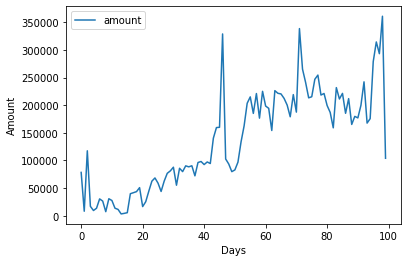

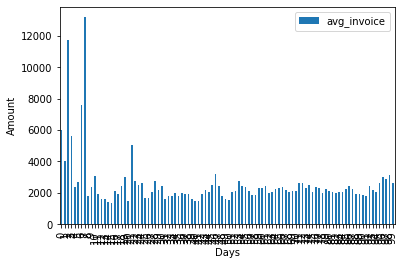

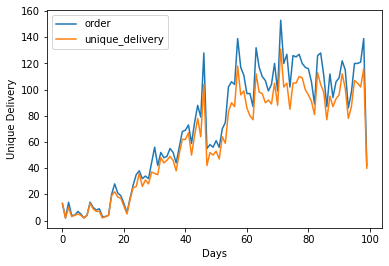

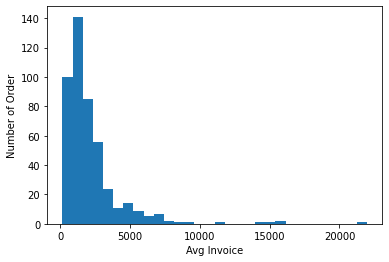

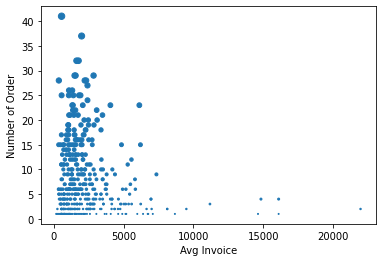

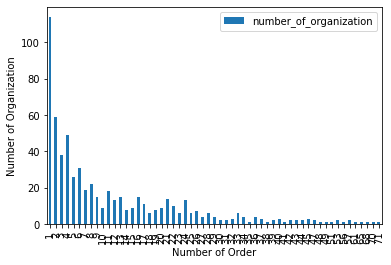

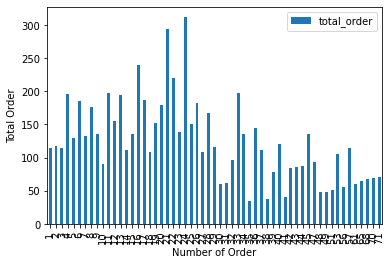

In [1]:
import csv
import pandas as pd
from datetime import datetime, timedelta
from pytz import timezone
import warnings
import matplotlib.pyplot as plt
from common.enums import Status
from pharmacy.enums import OrderTrackingStatus, PurchaseType, DistributorOrderType
warnings.filterwarnings('ignore')
localtz = timezone('Asia/Dhaka')
orders = Purchase.objects.filter(
    status=Status.DISTRIBUTOR_ORDER,
    distributor_order_type=DistributorOrderType.ORDER,
    purchase_type=PurchaseType.VENDOR_ORDER,
).exclude(
    current_order_status__in=[OrderTrackingStatus.REJECTED, OrderTrackingStatus.CANCELLED ]
).extra(
    select={
        "date": "date( created_at + interval '6 hour'  )"
    }
).values(
    'date'
).annotate(
    order=Count('id'),
    unique_delivery=Count('organization__id', distinct = True),
    amount=Sum('grand_total'),
)
df = pd.DataFrame(list(orders))
df['avg_invoice'] = df['amount']/df['unique_delivery']
df['days'] = df.reset_index().index
df.plot(x ='days', y=['amount'], kind = 'line')
plt.xlabel('Days')
plt.ylabel('Amount')
plt.show()
df.plot(x ='days', y=['avg_invoice'], kind = 'bar')
plt.ylabel('Amount')
plt.xlabel('Days')
plt.show()
df.plot(x ='days', y=['order', 'unique_delivery'], kind = 'line')
plt.xlabel('Days')
plt.ylabel('Unique Delivery')
plt.show()
last_30_days = Purchase.objects.filter(
    status=Status.DISTRIBUTOR_ORDER,
    distributor_order_type=DistributorOrderType.ORDER,
    purchase_type=PurchaseType.VENDOR_ORDER,
    created_at__gte=datetime.now()-timedelta(days=30)
).exclude(
    current_order_status__in=[OrderTrackingStatus.REJECTED, OrderTrackingStatus.CANCELLED ]
).values(
    'organization__name'
).annotate(
    order=Count('id'),
    amount=Sum('grand_total'),
)
df_30days = pd.DataFrame(list(last_30_days))
df_30days['avg_invoice'] = df_30days['amount']/df_30days['order']
plt.hist(df_30days.avg_invoice,  bins=30)
plt.ylabel('Number of Order')
plt.xlabel('Avg Invoice')
plt.show()
plt.scatter( df_30days.avg_invoice, df_30days.order, s=df_30days.order, label='quadratic')
plt.ylabel('Number of Order')
plt.xlabel('Avg Invoice')
plt.show()
organizations = Organization.objects.raw(
'''
SELECT 303 as id ,
        order_number, 
       number_of_organization, 
       order_number*number_of_organization AS total_order 
FROM   ( 
                SELECT   order_number, 
                         Count(id) AS number_of_organization 
                FROM     ( 
                                  SELECT   id, 
                                           Count(id) AS order_number 
                                  FROM     ( 
                                                  SELECT organization_id AS id, 
                                                         NAME, 
                                                         primary_mobile, 
                                                         Date(organization_cdate::timestamp at time zone 'Asia/Dhaka' ) AS organization_cdate,
                                                         Date(purchase_cdate::timestamp at time zone 'Asia/Dhaka')      AS purchase_cdate,
                                                         purchase_id, 
                                                         grand_total 
                                                  FROM   ( 
                                                                   SELECT    purchae.*, 
                                                                             core_organization.NAME,
                                                                             core_organization.primary_mobile,
                                                                             core_organization.created_at AS organization_cdate
                                                                   FROM      ( 
                                                                                    SELECT id AS purchase_id,
                                                                                           organization_id,
                                                                                           grand_total,
                                                                                           created_at AS purchase_cdate
                                                                                    FROM   pharmacy_purchase pp
                                                                                    WHERE  distributor_id = 303
                                                                                    AND    status=13
                                                                                    AND    distributor_order_type=2
                                                                                    AND    purchase_type=4
                                                                                    AND    pp.current_order_status NOT IN ( 7,
                                                                                                                           8 ) ) AS purchae
                                                                   LEFT JOIN core_organization 
                                                                   ON        purchae.organization_id = core_organization.id ) AS data) AS order_data
                                  GROUP BY id ) AS data 
                GROUP BY order_number ) AS data'''
)
rows = []
for item in organizations:
    data = {
        'id' : item.id,
        'order_number' : item.order_number,
        'number_of_organization' : item.number_of_organization,
        'total_order' :  item.total_order
    }
    rows.append(data)
col_list = ['id', 'order_number', 'number_of_organization', 'total_order']
newDF = pd.DataFrame(rows, columns=col_list)
newDF.plot(y='number_of_organization', x='order_number', kind = 'bar')
plt.xlabel('Number of Order')
plt.ylabel('Number of Organization')
plt.show()
newDF.plot(y='total_order', x='order_number', kind = 'bar')
plt.xlabel('Number of Order')
plt.ylabel('Total Order')
plt.show()